# Modelling and Evaluation Notebook

## Objectives

*   Answer business requirement 2: 
    * The client is interested in predicting if a cherry tree is healthy or contains powdery mildew.
    * The client wants a ML system that is capable of predicting whether a cherry leaf is healthy or contains powdery mildew.

## Inputs

* inputs/mildew_dataset/cherry-leaves/train
* inputs/mildew_dataset/cherry-leaves/test
* inputs/mildew_dataset/cherry-leaves/validation
* image shape embeddings.

## Outputs
* Images distribution plot in train, validation, and test set.
* Image augmentation.
* Class indices to change prediction inference in labels.
* Machine learning model creation and training.
* Save model.
* Learning curve plot for model performance.
* Model evaluation on pickle file.
* Prediction on the random image file.




## Additional Comments | Insights | Conclusions




---

# Import regular packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread
import plotly.express as px

---

# Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/mildew-detector')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/mildew-detector'

---

## Set input directories

Set train, validation and test paths

In [5]:
my_data_dir = 'inputs/mildew_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

## Set output directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

Old version is already available create a new version.


## Set labels

In [7]:

labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
)


Project Labels: ['healthy', 'powdery_mildew']


## Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

# Number of images in train, test and validation data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




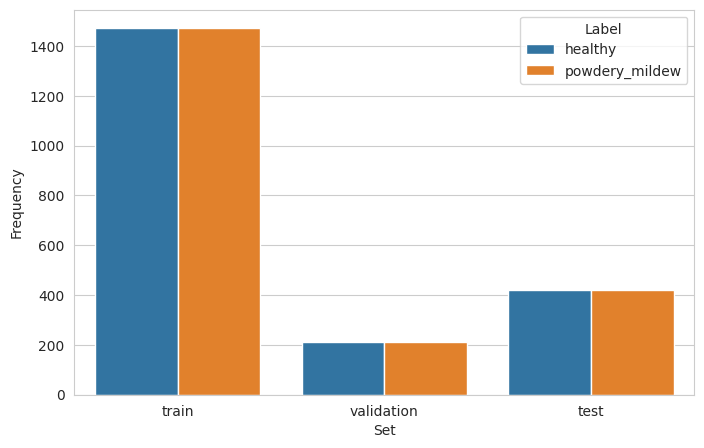

In [9]:
df_freq = pd.DataFrame([])
for folder in ['train', 'validation', 'test']:
    for label in labels:
        df_freq = df_freq.append(
            pd.Series(data={'Set': folder,
                            'Label': label,
                            'Frequency': int(len(os.listdir(my_data_dir + '/' + folder + '/' + label)))}
                      ),
            ignore_index=True
        )

        print(
            f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8, 5))
# create bar plot
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
# save figure to output directory
plt.savefig(f'{file_path}/labels_distribution.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Plot sunburst figure to visualize data proportions

In [ ]:

# drop duplicates to display correct frequency.
df_freq.drop_duplicates(subset=['Set', 'Label'], keep='first', inplace=True)
# create sunburst plot 
fig = px.sunburst(
    df_freq,
    path=['Set', 'Label'],
    values='Frequency',
    color='Label',
    title= 'Number of images in train, test and validation data',
    hover_name='Set', # set hover_name to display Set
    color_discrete_map={'healthy':'blue', 'powdery_mildew':'red'} # set colours for healthy and powdery_mildew
)
# save sunburst plot figure as static image in output directory
fig.write_image(f'{file_path}/labels_sunburst_distribution.png', format="png", scale=2)

fig.show()

---

# Image data augmentation

---

### ImageDataGenerator

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

* ### Initialize ImageDataGenerator

In [13]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                          width_shift_range=0.10,
                                          height_shift_range=0.10,
                                          shear_range=0.1,
                                          zoom_range=0.1,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          fill_mode='nearest',
                                          rescale=1./255
                                          )


* ### Augment training image dataset

In [14]:
batch_size = 20  # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                                     target_size=image_shape[:2],
                                                     color_mode='rgb',
                                                     batch_size=batch_size,
                                                     class_mode='binary',
                                                     shuffle=True
                                                     )

train_set.class_indices


Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment validation image dataset

In [15]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                                        target_size=image_shape[:2],
                                                                        color_mode='rgb',
                                                                        batch_size=batch_size,
                                                                        class_mode='binary',
                                                                        shuffle=False
                                                                        )

validation_set.class_indices


Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

* ### Augment test image dataset

In [16]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                                  target_size=image_shape[:2],
                                                                  color_mode='rgb',
                                                                  batch_size=batch_size,
                                                                  class_mode='binary',
                                                                  shuffle=False
                                                                  )

test_set.class_indices


Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

## Plot augmented training image

(20, 256, 256, 3)


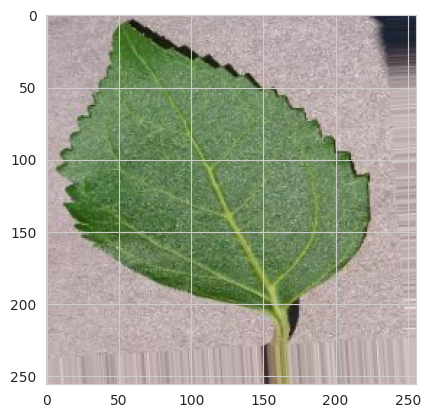

(20, 256, 256, 3)


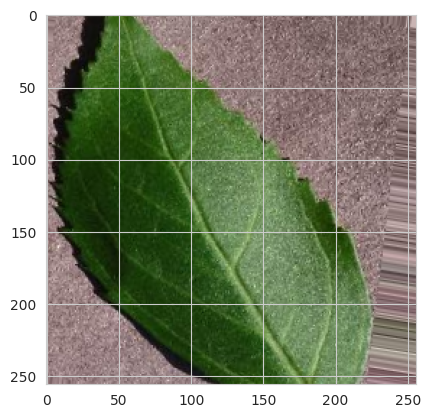

(20, 256, 256, 3)


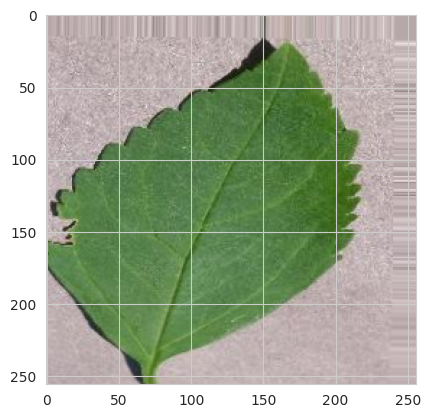

In [17]:
for _ in range(3):
    img, label = train_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Plot augmented validation and test images

(20, 256, 256, 3)


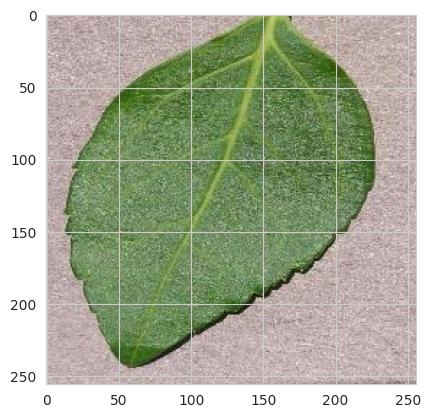

(20, 256, 256, 3)


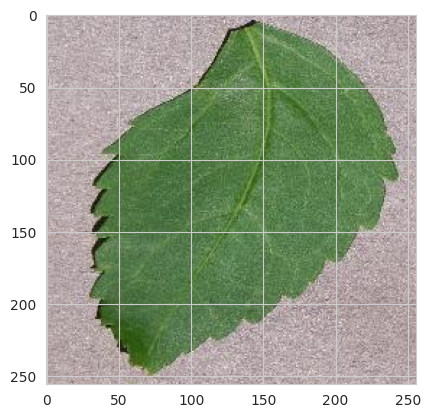

(20, 256, 256, 3)


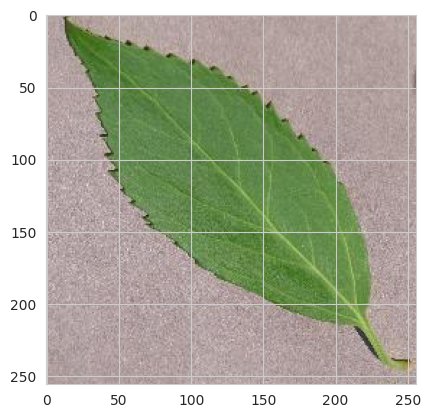

In [18]:
for _ in range(3):
    img, label = validation_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


(20, 256, 256, 3)


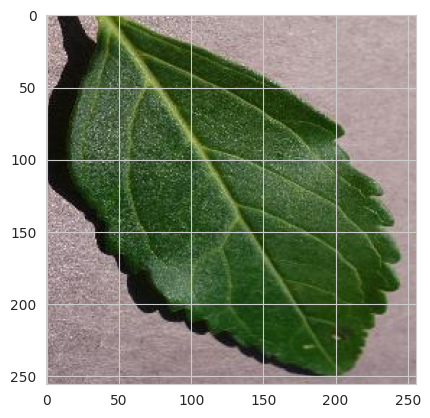

(20, 256, 256, 3)


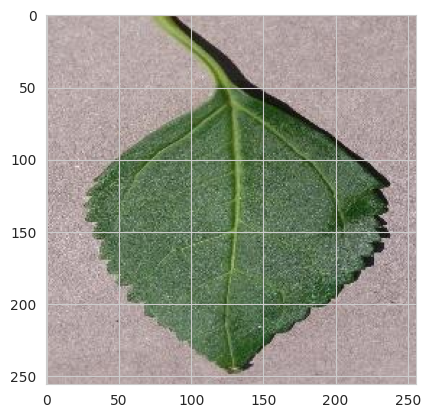

(20, 256, 256, 3)


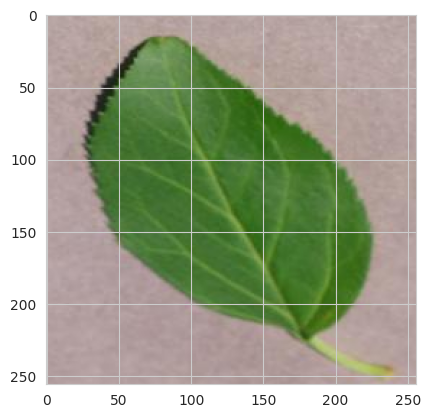

In [19]:
for _ in range(3):
    img, label = test_set.next()
    print(img.shape)  # (1,256,256,3)
    plt.imshow(img[0])
    plt.show()


## Save class_indices

In [20]:
joblib.dump(value=train_set.class_indices,
            filename=f"{file_path}/class_indices.pkl")


['outputs/v1/class_indices.pkl']

---

# Model creation

---

## ML model

* ### Import model packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model

* ### Model 

We use a Convolution neural network model. As this is a type of neural network which is commonly used for image processing and computer vision.

- Sequential model: The sequential model, arranges a sequence of layers in your neural network.
- Three sets of of pairs of Convolutional + Max Pooling layers with relu as the activation function are used in this model
- Conv2D: The convolution layers selects the dominant pixel value from the non-dominant pixels in images using filters. It allows you to find patterns (or features) in the image.
- MaxPooling2D: The Pooling layers reduces the image size by extracting only the dominant pixels (or features) from the image. The combination of these two layers removes the nonessential part of the image and reduces complexity.
- Flatten: The Flatten layer flattens the matrix into a vector, which means a single list of all values. That is fed into a dense layer.
- Dense layer with 128 neurons with relu as the activation function.
- Dropout: The dropout layer is a regularization layer and is used to reduce the chance of overfitting the neural network.
- The output layer has one neuron with sigmoid as the activation function.
- Loss function used is binary_crossentropy, as it is a binary classification.
- The optimizer used is rmsprop.

In [22]:

def create_tf_model():
    # instantiate a sequential model
    model = Sequential() 
    
    # 1st convolution and max pooling layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 2nd convolution and max pooling layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # 3rd convolution and max pooling layer
    model.add(Conv2D(filters=64, kernel_size=(3, 3),
              input_shape=image_shape, activation='relu', ))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # flatten layer
    model.add(Flatten())
    # dense layer
    model.add(Dense(128, activation='relu'))
    # dropout layer drops 50% nodes 
    model.add(Dropout(0.5))
    # output dense layer 
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])

    return model


* ### Model Summary 

In [23]:
create_tf_model().summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 57600)             0

2024-05-08 12:46:28.891292: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
plot_model(create_tf_model, show_shapes=True)

AttributeError: module 'pydot' has no attribute 'InvocationException'

* ### Early Stopping 

In [25]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=6)


## Fit model for model training

In [26]:
model = create_tf_model()
model.fit(train_set,
          epochs=25,
          steps_per_epoch=len(train_set.classes) // batch_size,
          validation_data=validation_set,
          callbacks=[early_stop],
          verbose=1
          )


2024-05-08 12:46:36.384908: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
147/147 [==============================] - 146s 988ms/step - loss: 0.6627 - accuracy: 0.7206 - val_loss: 0.1931 - val_accuracy: 0.9500
Epoch 2/25
147/147 [==============================] - 142s 963ms/step - loss: 0.2483 - accuracy: 0.9295 - val_loss: 0.1749 - val_accuracy: 0.9571
Epoch 3/25
147/147 [==============================] - 157s 1s/step - loss: 0.1466 - accuracy: 0.9562 - val_loss: 0.0927 - val_accuracy: 0.9905
Epoch 4/25
147/147 [==============================] - 150s 1s/step - loss: 0.1465 - accuracy: 0.9757 - val_loss: 0.2417 - val_accuracy: 0.9738
Epoch 5/25
147/147 [==============================] - 142s 966ms/step - loss: 0.0970 - accuracy: 0.9781 - val_loss: 0.0090 - val_accuracy: 0.9952
Epoch 6/25
147/147 [==============================] - 163s 1s/step - loss: 0.1147 - accuracy: 0.9812 - val_loss: 0.0208 - val_accuracy: 0.9976
Epoch 7/25
147/147 [==============================] - 166s 1s/step - loss: 0.0845 - accuracy: 0.9815 - val_loss: 0.0203 - val_accurac

## Save model

In [27]:
model.save('outputs/v1/mildew_detector_model.h5')

---

# Model Performace

---

## Model learning curve

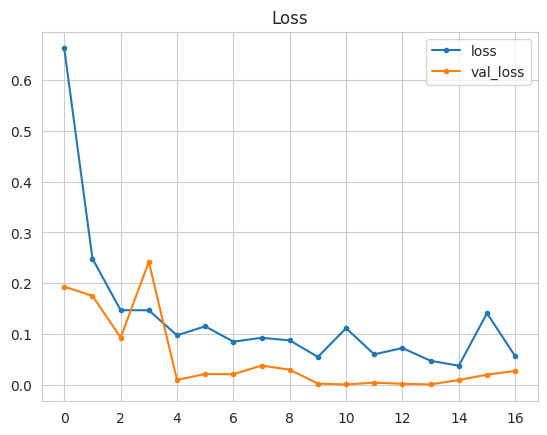

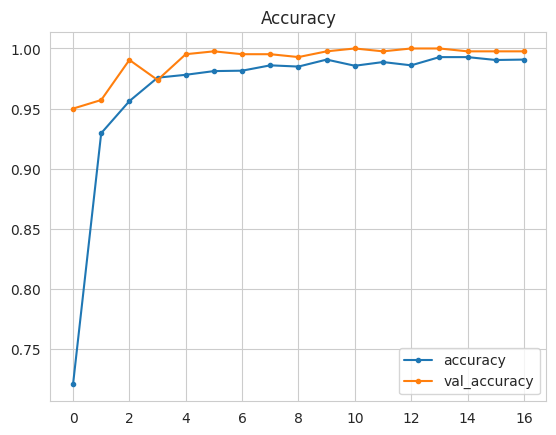

In [28]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss', 'val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png',
            bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy', 'val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png',
            bbox_inches='tight', dpi=150)
plt.show()


## Model Evaluation

Evaluate model on test set
* The performance on the test set meets the project requirement of at least 97% accuracy. 
* The model has been evaluated and found to have an accuracy of 99.76% .

Load saved model

In [29]:
from keras.models import load_model
model = load_model('outputs/v1/mildew_detector_model.h5')

Evaluate model on test set

In [30]:
evaluation = model.evaluate(test_set)

43/43 [==============================] - 9s 217ms/step - loss: 0.1908 - accuracy: 0.9976


### Save evaluation pickle

In [31]:
joblib.dump(value=evaluation,
            filename=f"outputs/v1/evaluation.pkl")

['outputs/v1/evaluation.pkl']

## Predict on new data

* The trained Ml model was used to predict on new data and was found to able to predict if a cherry leaf has powdery mildew in it or not.

Load a random image as PIL

Image shape: (256, 256), Image mode: RGB


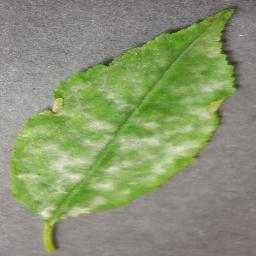

In [32]:
from tensorflow.keras.preprocessing import image

pointer = 112
label = labels[1]  # select powdery_mildew or healthy

pil_image = image.load_img(test_path + '/' + label + '/' + os.listdir(test_path+'/' + label)[pointer],
                           target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert image to array and prepare for prediction

In [33]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict class probabilities

In [34]:
pred_proba = model.predict(my_image)[0, 0]

target_map = {v: k for k, v in train_set.class_indices.items()}
pred_class = target_map[pred_proba > 0.5]

if pred_class == target_map[0]:
    pred_proba = 1 - pred_proba

print(pred_proba)
print(pred_class)

1.0
powdery_mildew


---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [35]:
!cat .gitignore

core.Microsoft*
core.mongo*
core.python*
env.py
__pycache__/
*.py[cod]
node_modules/
.github/
cloudinary_python.txt
kaggle.json
inputs/mildew_dataset/cherry-leaves/test
inputs/mildew_dataset/cherry-leaves/train

In [36]:
!git status

On branch main
Your branch is up to date with 'origin/main'.

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git restore <file>..." to discard changes in working directory)
	modified:   README.md
	modified:   app_pages/page_summary.py
	modified:   jupyter_notebooks/DataCollection.ipynb
	modified:   jupyter_notebooks/DataVisualization.ipynb
	modified:   jupyter_notebooks/ModellingAndEvaluation.ipynb
	modified:   outputs/v1/evaluation.pkl
	modified:   outputs/v1/mildew_detector_model.h5
	modified:   outputs/v1/model_training_acc.png
	modified:   outputs/v1/model_training_losses.png

no changes added to commit (use "git add" and/or "git commit -a")


In [37]:
!git add .

In [38]:
!git commit -am " Add new plots"

[main cab2c82]  Add new plots
 9 files changed, 319 insertions(+), 140 deletions(-)


In [39]:
!git push

Enumerating objects: 29, done.
Counting objects: 100% (29/29), done.
Delta compression using up to 16 threads
Compressing objects: 100% (13/13), done.
Writing objects: 100% (15/15), 45.27 MiB | 10.70 MiB/s, done.
Total 15 (delta 8), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (8/8), completed with 8 local objects.
remote: warning: See https://gh.io/lfs for more information.
remote: warning: File outputs/v1/mildew_detector_model.h5 is 56.73 MB; this is larger than GitHub's recommended maximum file size of 50.00 MB
remote: warning: GH001: Large files detected. You may want to try Git Large File Storage - https://git-lfs.github.com.
To https://github.com/md-ash-dot/mildew-detector.git
   342d7a4..cab2c82  main -> main


---

# Conclusions
* Checked number of images in train, test and validation data.
* Plotted barplot and sunburst nested pie plot to visualize the data and proportions.
* Image augmented training, validation and test set data.
* A CNN convolution neural network Ml model has been created , trained and evaluated.
* Prediction using the trained CNN Ml model on new data has worked succcessfully.
* A Machine learning model system that is capable of predicting whether a cherry leaf is healthy or contains powdery mildew is ready.
* The model has an accuracy of **99.76%**, which meets the agreed accuracy degree of 97%.
* Business requirement 2 has been met.


# Further steps
* Create a dashboard for the client.

---